# DEA Coastlines summary plots

In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

from dea_tools.coastal import get_coastlines


## Load data

In [ ]:
# Set study area from vector file
regions_gdf = (
    gpd.read_file(
        "https://data.dea.ga.gov.au/derivative/dea_coastlines/supplementary/australia_mainland_regions.geojson"
    )
    .set_index("Descriptio")
)
study_area = regions_gdf.loc[["Western Coasts"]]

In [7]:
# Load data from WFS for study area bounding box
bbox = study_area.geometry.bounds.values[0]
ratesofchange_gdf = get_coastlines(
    bbox=bbox, layer="rates_of_change"
)

# Clip returned data to polygon extent
ratesofchange_gdf = gpd.clip(ratesofchange_gdf, mask=study_area.to_crs("EPSG:3577"))
ratesofchange_gdf.head()

## Data prep

In [10]:
# Optional: Keep only rates of change points with "good" certainty 
# (i.e. no poor quality flags)
ratesofchange_gdf = ratesofchange_gdf.query("certainty == 'good'")

# Optional: Apply correction factor from Bishop-Taylor et al. 2021
ratesofchange_gdf.rate_time += 0.08

# Add x and y coords to data
ratesofchange_gdf["y_coord"] = ratesofchange_gdf.geometry.y
ratesofchange_gdf["x_coord"] = ratesofchange_gdf.geometry.x

In [11]:
# Resample to make sure we have evenly spaced rows (important for sensible rolling mean)
bin_size = 30
min_coord = ratesofchange_gdf["y_coord"].min()
max_coord = ratesofchange_gdf["y_coord"].max()
bin_edges = np.arange(min_coord, max_coord, bin_size)
groups = pd.cut(
    ratesofchange_gdf["y_coord"],
    bins=bin_edges,
    labels=bin_edges[:-1] + (bin_size / 2),
    right=False,
)
ratesofchange_standardised_gdf = ratesofchange_gdf.groupby(groups).mean()

# Set index to numeric so we can plot it nicely
ratesofchange_standardised_gdf.index = pd.to_numeric(
    ratesofchange_standardised_gdf.index
)

/tmp/ipykernel_552/1372165905.py:12: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  ratesofchange_standardised_gdf = ratesofchange_gdf.groupby(groups).mean()
/tmp/ipykernel_552/1372165905.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ratesofchange_standardised_gdf = ratesofchange_gdf.groupby(groups).mean()


## Rolling mean

In [18]:
# Apply rolling median
window_size = 15000  # km
window_n = int(window_size / 30)
ratesofchange_rolling_gdf = ratesofchange_standardised_gdf.rolling(
    window=window_n, center=True, min_periods=1
).mean()

# Apply an additional level of aesthetic smoothing (can be removed)
ratesofchange_rolling_gdf = ratesofchange_rolling_gdf.rolling(
    window=window_n, center=True, min_periods=1
).mean()

## Plotting

In [20]:
# Set first and last entry to zero so we get clean graph outlines
ratesofchange_rolling_gdf["rate_time"].iloc[0] = 0
ratesofchange_rolling_gdf["rate_time"].iloc[-1] = 0

# Split out positive and negative rates so we can plot them individually
ratesofchange_positive_gdf = ratesofchange_rolling_gdf["rate_time"].clip(0, np.inf)
ratesofchange_negative_gdf = ratesofchange_rolling_gdf["rate_time"].clip(-np.inf, 0)

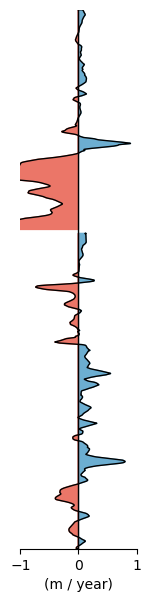

In [23]:
# Plot negative rates in red, positive in blue
fig, ax = plt.subplots(figsize=(1.5, 7))
ax.fill_betweenx(
    ratesofchange_positive_gdf.index, 0, ratesofchange_positive_gdf, color="#6caed1"
)
ax.fill_betweenx(
    ratesofchange_negative_gdf.index, ratesofchange_negative_gdf, 0, color="#eb7668"
)
ax.plot(
    ratesofchange_rolling_gdf["rate_time"],
    ratesofchange_rolling_gdf.index,
    color="black",
    linewidth=1,
)

# Add vertical axis line
ax.axvline(0, color="black", linewidth=1)

# Styling
ax.set_xlim(-1, 1)
ax.set_ylim(min_coord, max_coord)
ax.set_xticks(ticks=[-1, 0, 1])
ax.set_xlabel("(m / year)")
ax.spines[["top", "left", "right"]].set_visible(False)
ax.tick_params(top=False, left=False, labelleft=False, labeltop=False)

# Export
fig.savefig("output.png", bbox_inches="tight", transparent=True)